# Imports

In [27]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
import urllib.request
import seaborn as sns

# Fetch Data

In [2]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()  

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [161]:
train = load_titanic_data('train.csv')

# Data Exploration

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [162]:
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### With the majority of the data point for cabin are null, I will not include this column when creating the machine learning model

In [8]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
for col in ['Survived', 'Pclass','Sex', 'Embarked']:
    print (train[col].value_counts())

0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


# Prepared Data for ML

In [11]:
train.duplicated().sum()

0

In [12]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [25]:
num_columns = ['Age', 'SibSp', 'Parch', 'Fare']
cat_columns = ['Pclass', 'Sex']
embarked_mapper = train.groupby('Embarked')[['Survived']].mean().to_dict()['Survived']

In [128]:
from sklearn.base import BaseEstimator, TransformerMixin
class Mapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Apply the mapping to the input array (assuming X is a DataFrame or a Series)
        return pd.DataFrame(X).replace(self.mapping)

#### I have created a custom mapper which I will use for the embarked column using the mapper I created

In [173]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_columns = ['Age', 'SibSp', 'Parch', 'Fare']
cat_columns = ['Pclass', 'Sex']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

embarked_pipline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('mapper', Mapper(embarked_mapper))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns),
        ('embarked', embarked_pipline, ['Embarked'])
    ])


In [174]:
preprocessor.fit(train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 ['Pclass', 'Sex']),
                                ('embarked',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('mapper',
                                                  Mapper(mapping={'C': 0.5535714285714286,
                                                                  'Q': 0.38961038961038963,
                                                                  'S': 0.33695652173913043}))]),
                                 ['Embarked'])])

In [175]:
X_train_prepared = preprocessor.transform(train)

In [190]:
y = train['Survived']

In [177]:
columns = []
columns.extend(num_columns)
for column in preprocessor.transformers_[1][1][1].categories_:
    columns.extend(column)
columns.extend(['Embarked'])

In [178]:
pd.DataFrame(X_train_prepared, columns=columns)

,Age,SibSp,Parch,Fare,1,2,3,female,male,Embarked
0,-0.565736,0.432793,-0.473674,-0.502445,0.0,0.0,1.0,0.0,1.0,0.336957
1,0.663861,0.432793,-0.473674,0.786845,1.0,0.0,0.0,1.0,0.0,0.553571
2,-0.258337,-0.474545,-0.473674,-0.488854,0.0,0.0,1.0,1.0,0.0,0.336957
3,0.433312,0.432793,-0.473674,0.420730,1.0,0.0,0.0,1.0,0.0,0.336957
4,0.433312,-0.474545,-0.473674,-0.486337,0.0,0.0,1.0,0.0,1.0,0.336957
...,...,...,...,...,...,...,...,...,...,...
886,-0.181487,-0.474545,-0.473674,-0.386671,0.0,1.0,0.0,0.0,1.0,0.336957
887,-0.796285,-0.474545,-0.473674,-0.044381,1.0,0.0,0.0,1.0,0.0,0.336957
888,-0.104637,0.432793,2.008933,-0.176263,0.0,0.0,1.0,1.0,0.0,0.336957
889,-0.258337,-0.474545,-0.473674,-0.044381,1.0,0.0,0.0,0.0,1.0,0.553571


In [191]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_prepared, y, test_size=0.2, random_state=42)

## Apply machine learning algorithms

In [180]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine (Linear Kernel)': SVC(random_state=42, kernel='linear'),
    'Support Vector Machine (Gaussian Kernel)': SVC(random_state=42, kernel='rbf'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Stochastic Gradient Descent': SGDClassifier(random_state=42),
    'Gaussian Process': GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    'Ada Boost' : GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    'MLP' : MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'Gaussian Naive Bayes' : GaussianNB()

}


In [181]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List to store results
results = []

# Evaluate each classifier
for name, clf in classifiers.items():
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_train)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_train, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_train, y_pred, average='binary', zero_division=0)
    
    # Store the results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.806180,0.777778,0.679104,0.725100
1,Random Forest,0.978933,0.988417,0.955224,0.971537
2,Support Vector Machine (Linear Kernel),0.787921,0.738776,0.675373,0.705653
3,Support Vector Machine (Gaussian Kernel),0.839888,0.818182,0.738806,0.776471
4,K-Nearest Neighbors,0.853933,0.833333,0.764925,0.797665
5,Stochastic Gradient Descent,0.789326,0.801020,0.585821,0.676724
6,Gaussian Process,0.845506,0.837607,0.731343,0.780876
7,Ada Boost,0.845506,0.837607,0.731343,0.780876
8,MLP,0.844101,0.836910,0.727612,0.778443
9,Gaussian Naive Bayes,0.796348,0.726937,0.735075,0.730983


### I will inspect the random forest model because it performed significantly better than the other models

In [182]:
# Mean tree depth
mean_tree_depth = np.mean([estimator.tree_.max_depth for estimator in classifiers['Random Forest'].estimators_])
print(f"Mean Tree Depth: {mean_tree_depth}")

# Feature importances
feature_importances = classifiers['Random Forest'].feature_importances_
print("Feature Importances:")
for importance, i in sorted(zip(feature_importances, columns), reverse=True):
    print(f"Feature {i}: {importance:.4f}")

# Number of trees in the forest
n_estimators = classifiers['Random Forest'].n_estimators
print(f"Number of Estimators (Trees): {n_estimators}")


Mean Tree Depth: 17.99
Feature Importances:
Feature Fare: 0.2549
Feature Age: 0.2479
Feature female: 0.1661
Feature male: 0.1250
Feature 3: 0.0588
Feature SibSp: 0.0451
Feature Parch: 0.0334
Feature Embarked: 0.0323
Feature 1: 0.0223
Feature 2: 0.0141
Number of Estimators (Trees): 100


#### Fare, age, and gender are very important when making predictions and the p class is more important when the value is 3 than any other value.

## Hyper Parameter Tuning

In [184]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [10, 15, 18, 20, 25],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required to be at a leaf node
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV with the specified parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters and mean tree depth
print("Best Parameters found by Grid Search:")
print(grid_search.best_params_)

# Extract and print mean tree depth from the best estimator
best_rf = grid_search.best_estimator_
mean_tree_depth = np.mean([estimator.tree_.max_depth for estimator in best_rf.estimators_])
print(f"Mean Tree Depth: {mean_tree_depth}")

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Parameters found by Grid Search:
{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Mean Tree Depth: 13.67


## Evaluating our model on the test data

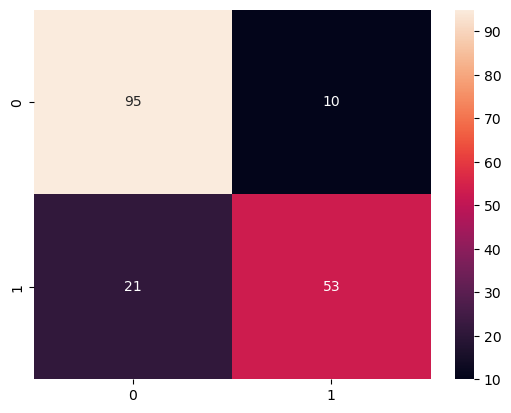

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.84      0.72      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



In [196]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = best_rf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
plt.show()
print(classification_report(y_test, predictions))

### The results of the model show that our precision is similar between the two classes at 82% for non survivors and 84% for survivors. In the case of recall, and our model was able to catch 90% of all non-survivors in that data set, but only caught 72% of the survivors in the data set.